In [34]:
# Importera nödvändiga bibliotek
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Ladda och förbered data

In [35]:
# Läs in datasets
market_research = pd.read_csv('adjusted_market_research.csv')
transactions = pd.read_csv('transactions.csv')

print("Market Research Data:")
print(market_research.head())

print("\nTransaction Data:")
print(transactions.head())


Market Research Data:
   SurveyID  CustomerID  SatisfactionScore  RecommendationLikelihood Comments  \
0         1        3598                  8                         7  Neutral   
1         2        1117                  2                         7     Poor   
2         3        2282                  6                         2     Poor   
3         4        2089                  8                         3     Good   
4         5        1897                  3                         8  Neutral   

   AdjustedCustomerID  
0                4100  
1                2054  
2                2282  
3                2055  
4                4107  

Transaction Data:
   TransactionID  CustomerID      TransactionDate  Amount     Category
0              0        2869  2023-01-01 00:00:00  242.74  Electronics
1              1        1424  2023-01-01 01:00:00  132.46     Clothing
2              2        1948  2023-01-01 02:00:00   66.99     Clothing
3              3        3414  2023-01-01 03:

In [36]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

print(transactions.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   int64         
 1   CustomerID       1000 non-null   int64         
 2   TransactionDate  1000 non-null   datetime64[ns]
 3   Amount           1000 non-null   float64       
 4   Category         1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 39.2+ KB
None


In [37]:

last_transaction = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction.columns = ['CustomerID', 'LastTransactionDate']

print(last_transaction.head())


   CustomerID LastTransactionDate
0        1000 2023-01-25 08:00:00
1        1006 2023-01-21 07:00:00
2        1008 2023-01-28 20:00:00
3        1020 2023-01-05 07:00:00
4        1025 2023-01-02 11:00:00


In [38]:
today = pd.to_datetime("2023-02-15")
last_transaction['DaysSinceLastTransaction'] = (today - last_transaction['LastTransactionDate']).dt.days

print(last_transaction.head())


   CustomerID LastTransactionDate  DaysSinceLastTransaction
0        1000 2023-01-25 08:00:00                        20
1        1006 2023-01-21 07:00:00                        24
2        1008 2023-01-28 20:00:00                        17
3        1020 2023-01-05 07:00:00                        40
4        1025 2023-01-02 11:00:00                        43


In [39]:
merged_data = pd.merge(market_research, last_transaction, on='CustomerID', how='left')

merged_data['DaysSinceLastTransaction'] = merged_data['DaysSinceLastTransaction'].fillna(9999)

In [ ]:
if 'SatisfactionScore' not in merged_data.columns or 'RecommendationLikelihood' not in merged_data.columns:
    raise ValueError("Required columns 'SatisfactionScore' or 'RecommendationLikelihood' are missing.")

# Definiera churn baserat på regler
merged_data['Churn'] = merged_data.apply(
    lambda row: 1 if row['DaysSinceLastTransaction'] > 30 or 
                      row['SatisfactionScore'] < 5 or 
                      row['RecommendationLikelihood'] < 5 else 0,
    axis=1
)

print(merged_data[['CustomerID', 'DaysSinceLastTransaction', 'SatisfactionScore', 'RecommendationLikelihood', 'Churn']].head())

   CustomerID  DaysSinceLastTransaction  SatisfactionScore  \
0        3598                    9999.0                  8   
1        1117                    9999.0                  2   
2        2282                      22.0                  6   
3        2089                    9999.0                  8   
4        1897                    9999.0                  3   

   RecommendationLikelihood  Churn  
0                         7      1  
1                         7      1  
2                         2      1  
3                         3      1  
4                         8      1  


In [41]:
# Välj funktioner och målvariabel
X = merged_data[['DaysSinceLastTransaction', 'SatisfactionScore', 'RecommendationLikelihood']]
y = merged_data['Churn']

# Dela upp data

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [43]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [44]:

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

predictions = model.predict(X_test)


In [45]:
predictions = model.predict(X_test)

# Utvärdera modellen

In [46]:
# Utvärdera modellen
print("\nModel Performance Metrics:")
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))



Model Performance Metrics:
Accuracy: 0.9933333333333333
Precision: 0.9928057553956835
Recall: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.99      1.00      1.00       138

    accuracy                           0.99       150
   macro avg       1.00      0.96      0.98       150
weighted avg       0.99      0.99      0.99       150



# Visualisera funktionens betydelse

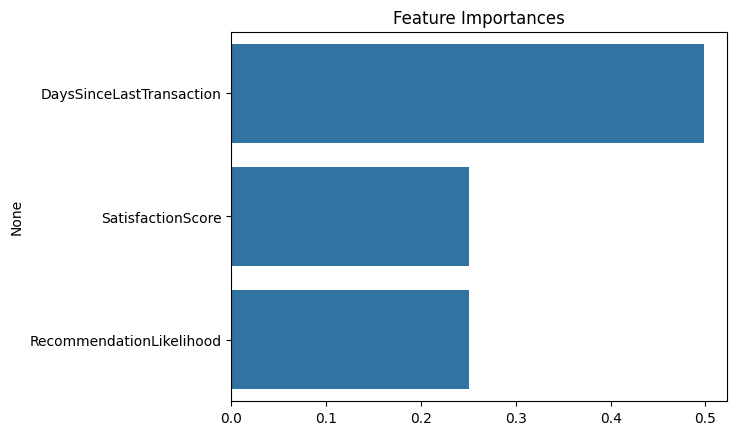

In [47]:
# Visualisera viktiga funktioner
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.show()

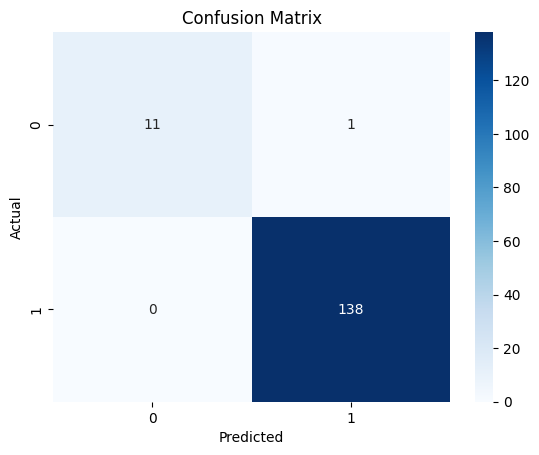

In [48]:
# Visualisera confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Churn
1    461
0     39
Name: count, dtype: int64


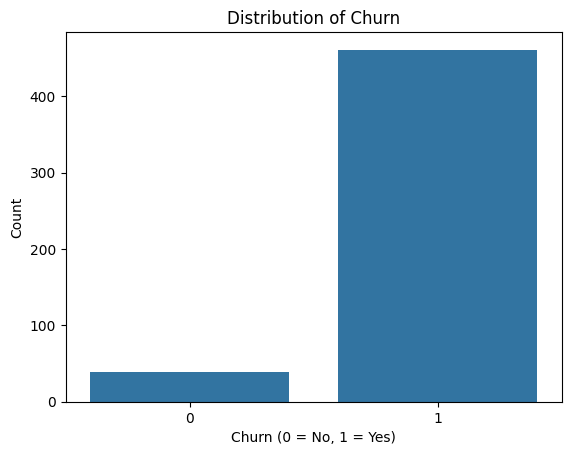

In [49]:
# Visualisera fördelningen av Churn
print(merged_data['Churn'].value_counts())
sns.countplot(x='Churn', data=merged_data)
plt.title('Distribution of Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()